# 关于开放群岛开源社区大模型SIG

# 项目介绍

# 项目Demo

## 1. 检查PaddleOCR版本

In [1]:
import paddleocr
print(paddleocr.__version__)

PLEASE USE OMP_NUM_THREADS WISELY.


2.7.0.2


## 2. 使用PaddleOCR端到端的解决方案完成文字识别

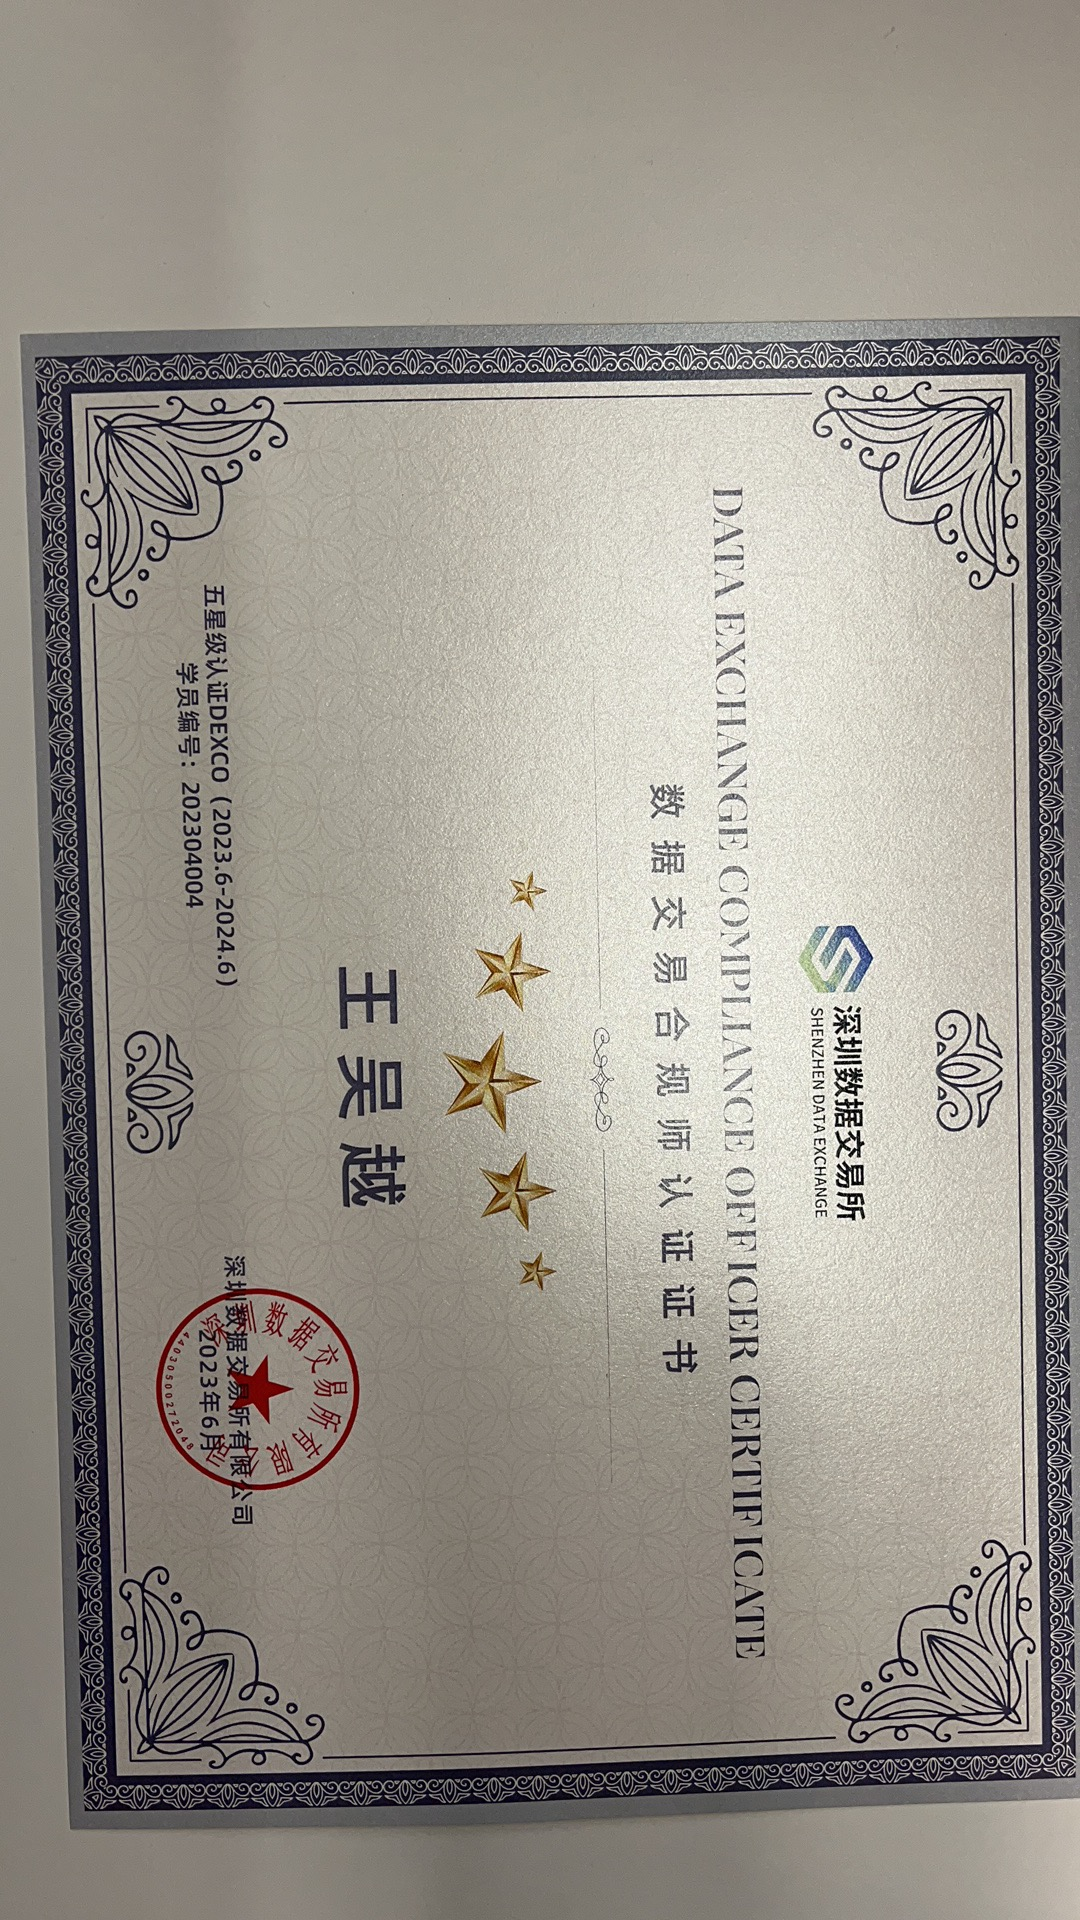

In [7]:
from PIL import Image
image_path = '/root/sample03.jpg'
image = Image.open(image_path)
image.show()

在上图中，我需要识别出

In [3]:
from paddleocr import PaddleOCR, draw_ocr

# Paddleocr目前支持的多语言语种可以通过修改lang参数进行切换
# 例如`ch`, `en`, `fr`, `german`, `korean`, `japan`
ocr = PaddleOCR(use_angle_cls=True, lang="ch")  # need to run only once to download and load model into memory
img_path = '/root/sample03.jpg'
result = ocr.ocr(img_path, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

# 显示结果
# 如果本地没有simfang.ttf，可以在doc/fonts目录下下载
from PIL import Image
result = result[0]
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='/root/PaddleOCR/doc/fonts/simfang.ttf')
im_show = Image.fromarray(im_show)
im_show.save('result.jpg')

[2023/08/14 13:04:42] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set

3. 查看识别结果

In [4]:
txts

['DATA EXCHANGE COMPLIANCE OFFICER CERTIFICATE',
 '五星级认证DEXCO（2023.6-2024.6）',
 '学员编号：202304004',
 '05205c05205c05c05205',
 '数据交易合规师认证证书',
 '王吴越',
 '深圳数据交易所',
 'O',
 'CO5',
 '深圳',
 '交易所']

4. 构造Prompt (Prompt出处来自飞桨团队，针对ChatGLM2-6B进行了微调)

    4.1 定义要抽取的Schema

In [4]:
ocr_result=txts
key='{\'证书名称\',\'姓名\',\'学员编号\',\'认证星级\',\'认证期限\'}'

    4.2 查看构造好的Prompt

In [29]:
prompt = f"""你现在的任务是从OCR文字识别的结果中提取我指定的关键信息。OCR的文字识别结果使用```符号包围，包含所识别出来的文字，顺序在原始图片中从左至右、从上至下。我指定的关键信息使用[]符号包围。请注意OCR的文字识别结果可能存在长句子换行被切断、不合理的分词、对应错位等问题，你需要结合上下文语义进行综合判断，以抽取准确的关键信息。在返回结果时使用json格式，包含一个key-value对，key值为我指定的关键信息，value值为所抽取的结果。如果认为OCR识别结果中没有关键信息key，则将value赋值为“未找到相关信息”。请只输出json格式的结果，不要包含其它多余文字！下面正式开始：\n\nOCR文字：```{ocr_result}```\n\n要抽取的关键信息：[{key}]。\n\n请只输出JSON字典，不要输出额外内容！"""
print(prompt)

你现在的任务是从OCR文字识别的结果中提取我指定的关键信息。OCR的文字识别结果使用```符号包围，包含所识别出来的文字，顺序在原始图片中从左至右、从上至下。我指定的关键信息使用[]符号包围。请注意OCR的文字识别结果可能存在长句子换行被切断、不合理的分词、对应错位等问题，你需要结合上下文语义进行综合判断，以抽取准确的关键信息。在返回结果时使用json格式，包含一个key-value对，key值为我指定的关键信息，value值为所抽取的结果。如果认为OCR识别结果中没有关键信息key，则将value赋值为“未找到相关信息”。请只输出json格式的结果，不要包含其它多余文字！下面正式开始：

OCR文字：```['DATA EXCHANGE COMPLIANCE OFFICER CERTIFICATE', '五星级认证DEXCO（2023.6-2024.6）', '学员编号：202304004', '05205c05205c05c05205', '数据交易合规师认证证书', '王吴越', '深圳数据交易所', 'O', 'CO5', '深圳', '交易所']```

要抽取的关键信息：[{'证书名称','姓名','学员编号','认证星级','认证期限'}]。

请只输出JSON字典，不要输出额外内容！


5. 加载ChatGLM2-6B模型

In [6]:
from zhipuai import ZhipuAI
client = ZhipuAI(api_key="") # 填写您自己的APIKey
response = client.chat.completions.create(
    model="glm-4",  # 填写需要调用的模型名称
    messages=[
        {"role": "user", "content": prompt},
    ],
)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [30]:
print(response.choices[0].message)

{
"证书名称": "数据交易合规师认证证书",
"姓名": "王吴越",
"学员编号": "202304004",
"认证星级": "五星级认证DEXCO（2023.6-2024.6）",
"认证期限": "2023.6-2024.6"
}
